# Data driven heart disease prediction

Siddharth Garimella

## Introduction

Heart disease is the leading cause of death for both men and women, and improvements in our ability to predict its presence early on could lead to better outcomes for many patients. Using the data from the Cleveland Heart Disease database, I aim to produce a model capable of estimating the probability a patient has heart disease given a limited set of biomedical information. The data provided includes data on 180 cases, and is available on DrivenData's website [here](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart).

The challenge provided is exploratory in nature, but does rank submissions by evaluating the model on unseen data. Participants  must abide by the [rules](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/rules/) that DrivenData has established for the competition.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
import itertools
import warnings

from copy import copy
from tpot import TPOTClassifier, TPOTRegressor
from tpot.builtins import StackingEstimator
from imblearn.over_sampling import SMOTE
from matplotlib.legend_handler import HandlerLine2D
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, PolynomialFeatures, FunctionTransformer, Normalizer
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression
from sklearn.ensemble import *
from sklearn.feature_selection import SelectFwe, f_classif
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import clone

plt.rcParams['figure.figsize'] = [8,8]
warnings.filterwarnings('ignore')

c:\python37\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
c:\python37\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\python37\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\python37\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\python37\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Exploring the data

Datadriven provides patient data with a variety of features we can use to predict the probability a patient is likely to suffer from some form of heart disease. We will look at the way the train/test data is structured, split, and distributed.

In [4]:
# Training data
train_values = pd.read_csv("data/train_values.csv")
train_labels = pd.read_csv("data/train_labels.csv")
# Testing data
test_values = pd.read_csv("data/test_values.csv")

In [5]:
train_values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


It is apparent both quantitative and categorical variables exist in the dataset.

In [6]:
train_labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [7]:
split = len(train_values)/(len(train_values)+len(test_values))
(split, 1-split)

(0.6666666666666666, 0.33333333333333337)

The train-test split is 2/3 training data and 1/3 testing data.

In [6]:
train_labels["heart_disease_present"].mean()

0.4444444444444444

44% of patients in the training set have some form of heart disease. There is little class imbalance.

In [7]:
train_values.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000


Demographic in training data: 68.9% of patients in the dataset are male, and the average patient age is 54.8. From the results below, the testing data does not appear to be very different.

In [8]:
test_values.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,1.655556,131.411111,3.211111,0.622222,0.122222,0.966667,250.555556,1.130000,0.655556,53.677778,150.066667,0.355556
std,0.602637,19.552806,0.977206,0.894148,0.329377,0.999438,49.835936,1.193847,0.477849,8.641197,25.351817,0.481363
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,166.000000,0.000000,0.000000,34.000000,71.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,212.250000,0.000000,0.000000,46.250000,136.500000,0.000000
50%,2.000000,130.000000,4.000000,0.000000,0.000000,0.000000,243.500000,0.800000,1.000000,54.000000,156.500000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,274.750000,1.875000,1.000000,60.000000,164.750000,1.000000
max,3.000000,200.000000,4.000000,3.000000,1.000000,2.000000,409.000000,4.000000,1.000000,76.000000,195.000000,1.000000


In [278]:
# 'thal' and 'patient_id' are not quantitative
# 'patient_id' can be thrown out as long as order in the data in both the values and labels is preserved
# 'thal' can be one hot encoded

def ohe(data):
    if 'thal' in data:
        one_hot = pd.get_dummies(data['thal'])
        data = data.drop('thal',axis = 1)
        data = data.join(one_hot)
    if 'patient_id' in data:
        data = data.drop('patient_id',axis=1)
    return data

test_values = ohe(test_values)
train_values = ohe(train_values)
train_values.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,fixed_defect,normal,reversible_defect
0,1,128,2,0,0,2,308,0.0,1,45,170,0,0,1,0
1,2,110,3,0,0,0,214,1.6,0,54,158,0,0,1,0
2,1,125,4,3,0,2,304,0.0,1,77,162,1,0,1,0
3,1,152,4,0,0,0,223,0.0,1,40,181,0,0,0,1
4,3,178,1,0,0,2,270,4.2,1,59,145,0,0,0,1


All variables are in numerical form now, but there still exist categorical variables. I want to visualize the distributions of all the quantitative variables in the dataset. The most unique values in any categorical variable in the dataset is 4, so I will draw a CDF for every variable with more than 4 variables.

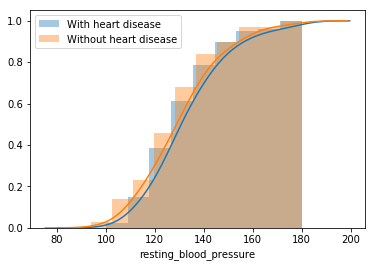

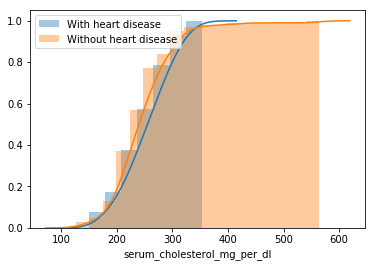

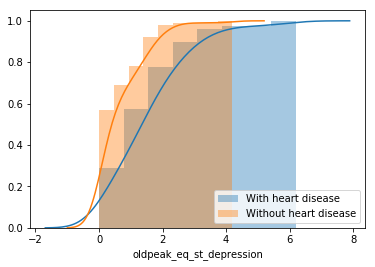

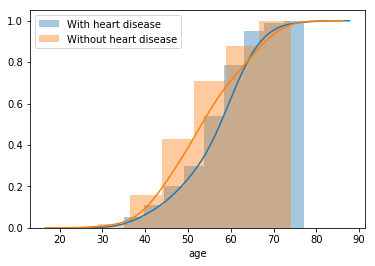

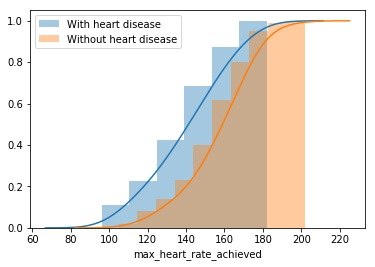

In [10]:
# Visualize distributions for quantitative variables
for target in train_values.columns:
    if train_values[target].nunique() > 4:
        plt.figure()
        sns.distplot(train_values[train_labels['heart_disease_present'] == 1][target], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),label="With heart disease")
        sns.distplot(train_values[train_labels['heart_disease_present'] == 0][target], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),label="Without heart disease")
        plt.legend()

Major discrepancies in the distributions between patients with and without heart disease can be observed in the features 'oldpeak_eq_st_depression', 'age', and 'max_heart_rate_achieved'. Patients without heart disease tend to be younger, achieve a higher maximum heart rate, and have a lower ST depression induced by exercise relative to rest.

I will now look at whether or not these quantitative variables have any observable association with each other.

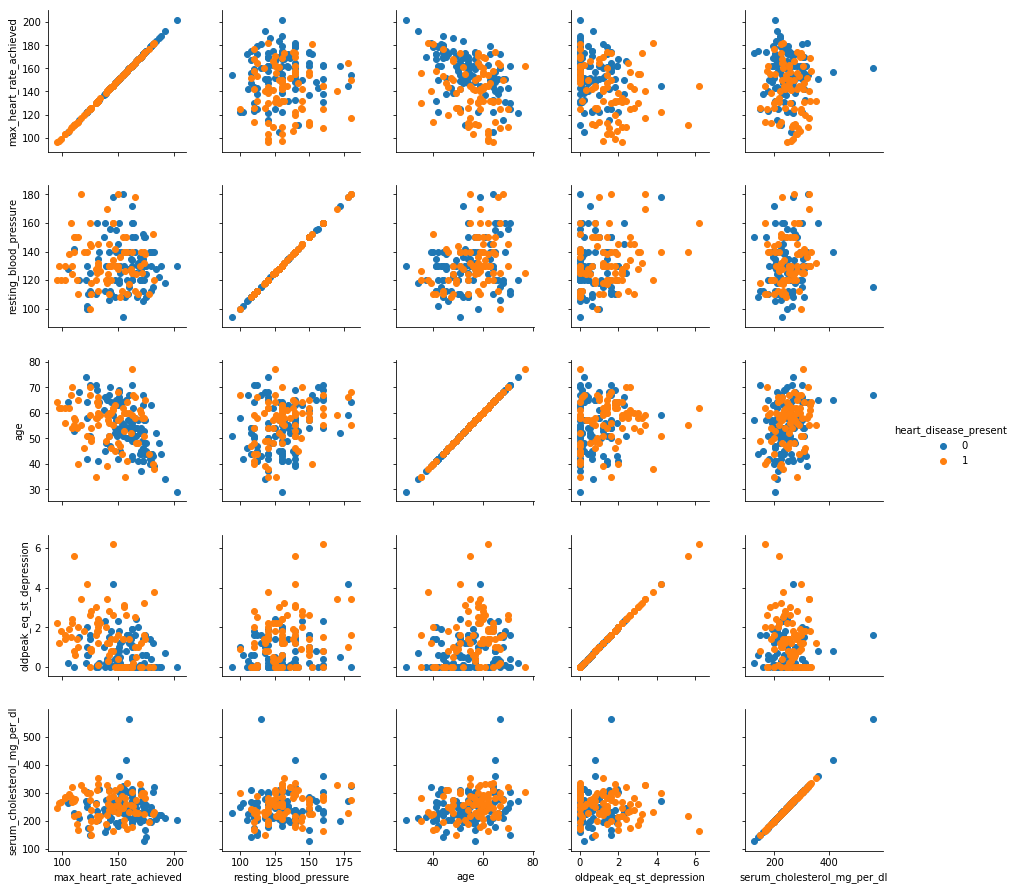

In [11]:
# Visualize pairwise quantitative relationships
train_with_labels = train_values
train_with_labels["heart_disease_present"] = train_labels["heart_disease_present"] 
g = sns.PairGrid(train_with_labels, hue="heart_disease_present", vars=["max_heart_rate_achieved", "resting_blood_pressure", "age", "oldpeak_eq_st_depression", "serum_cholesterol_mg_per_dl"])
g.map(plt.scatter);
g.add_legend();

No linear association is immediately observable. If there is a relationship between the variables above, it is likely non-linear. A correlation plot helps compare "how associated" some pairs are over others.

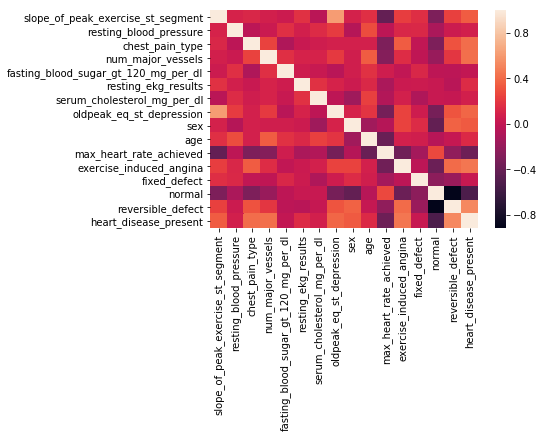

In [12]:
corr = train_with_labels.corr();
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

The greatest correlation apparent above is between the two electrocardiographic variables 'oldpeak_eq_st_depression' and 'slope_of_peak_exercise_st_segment'.

It is more important to know which variables matter for classification now, however, I'll use a random forest to rank features by their importance. Random forests do this by basing the "importance" of a feature on the mean prediction error of trees that did not sample the feature.

In [13]:
def rank_features(values, labels):
    if 'heart_disease_present' in values:
        values = values.drop('heart_disease_present',axis=1)
    rf_ranker = RandomForestClassifier(n_estimators=1000, min_samples_leaf=15, criterion='entropy', n_jobs=-1, oob_score=True, random_state=42)
    rf_ranker.fit(values, labels) 
    feature_importances = pd.DataFrame(rf_ranker.feature_importances_, index = values.columns, columns=['importance']).sort_values('importance',ascending=False)
    return feature_importances

rank_features(train_values, train_labels['heart_disease_present'])

,importance
reversible_defect,0.156403
chest_pain_type,0.148675
normal,0.146892
exercise_induced_angina,0.094976
num_major_vessels,0.088300
max_heart_rate_achieved,0.079792
oldpeak_eq_st_depression,0.076892
slope_of_peak_exercise_st_segment,0.051136
age,0.050071
sex,0.040519


It appears that the type of chest pain and whether or not the patient had a "reversible_defect" or "normal" thalium stress test result serve as the three most important predictors of heart disease in patients.

# Modeling the data

The dataset provided is not particularly large and there are no clear relationships between variables in the data (e.g. no clusters, linear relationships, etc.). A lightweight model that could potentially provide good predictions without overfitting the data is a random forest, which I'll use to model the data first.

Before that, however, I need to define a good way to evaluate model accuracy, given the size of the dataset. Datadriven's official scoring metric is the log-loss function, which heavily penalizes high confidence answers that are wrong. This makes practical sense, as high confidence answers could strongly evidence inaction for patients that may actually require treatment.

There is a little class imbalance and not much data, so I'll score based on the average log-loss across 10 folds of data that represent the distribution of each class accurately in each fold.

In [115]:
if 'heart_disease_present' in train_values:
    train_values = train_values.drop("heart_disease_present", axis=1)

def score(model, values, labels):
    skf = StratifiedKFold(n_splits=10)
    ll_s = []
    in_s = []
    for train, test in skf.split(values, labels):
        model.fit(values.iloc[train], labels.iloc[train])
        y_prob = model.predict_proba(values.iloc[test])
        y_prob = y_prob[:, 1]
        loss = log_loss(labels.iloc[test], y_prob)
        ll_s.append(loss)
    X_train, X_test, y_train, y_test = train_test_split(values, labels, test_size=0.33, random_state=42)
    model = clone(model)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, values, labels, cv=10);
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("K=10 LOG LOSS: " + str(np.mean(ll_s)))
    print("MODEL SCORE: " + str(model.score(X_test, y_test)))
    print("CV=10 SCORE: " + str(scores.mean()))
    print("ROC AUC: " + str(roc_auc))

In [116]:
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, n_jobs=-1, oob_score=True, random_state=42);
score(rf, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.41671039194783077
MODEL SCORE: 0.8
CV=10 SCORE: 0.8277777777777777
ROC AUC: 0.8181818181818181


I'll compare this score to a couple other models.

In [118]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
score(sgd, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 15.926444554688652
MODEL SCORE: 0.45
CV=10 SCORE: 0.5611111111111111
ROC AUC: 0.5


In [119]:
glf = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=3)
score(glf, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.8516043607654824
MODEL SCORE: 0.7833333333333333
CV=10 SCORE: 0.788888888888889
ROC AUC: 0.7962962962962963


In [120]:
mlpc = MLPClassifier()
score(mlpc, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 1.3031827792878283
MODEL SCORE: 0.8166666666666667
CV=10 SCORE: 0.711111111111111
ROC AUC: 0.8333333333333333


In [121]:
etc = ExtraTreesClassifier(n_estimators=1000, min_samples_leaf=3, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
score(etc, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.43221559737831594
MODEL SCORE: 0.75
CV=10 SCORE: 0.8166666666666667
ROC AUC: 0.7693602693602694


In [123]:
abc = AdaBoostClassifier(n_estimators=1000)
score(abc, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.681254972500237
MODEL SCORE: 0.75
CV=10 SCORE: 0.7444444444444445
ROC AUC: 0.7626262626262625


In [122]:
bgc = BaggingClassifier(n_estimators=1000)
score(bgc, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.43532550422883
MODEL SCORE: 0.8166666666666667
CV=10 SCORE: 0.788888888888889
ROC AUC: 0.8333333333333333


Looks like the best options are a gradient boosting classifier, bagging classifier, extra trees classifier, and a random forest. I will tune these later and see which one in particular to go with.

A "Reliability curve", which is essentially just a CDF of predicted class probabilities can be used to visualize and calibrate the distribution of output probabilities to that which is expected by Datadriven. It is important to note that what is being evaluated here is not the final classification, but class probability. This means a 0.9 will incur a much more serious loss if incorrect than 0.6, and the spread of probabilities matters quite a bit to Datadriven's evaluation.

Two ways class probability may be reached is by tuning a classification algorithm and using the same hyperparameters on a regressor derived from the same model, or by using the classification algorithms' parameters to calculate the class probability.

In [108]:
def probability_plot(model, values, labels):
    X_train, X_test, y_train, y_test = train_test_split(values, labels, test_size=0.33, random_state=42)
    import warnings
    warnings.filterwarnings('ignore')
    model.fit(X_train,y_train);
    y_prob = [x[1] for x in model.predict_proba(X_test)]
    from sklearn.calibration import calibration_curve
    frac, mp = calibration_curve(y_test, y_prob, n_bins=9)
    plt.figure(figsize=[3,3])
    plt.plot(mp,frac,label="Classifier probabilities")
    plt.legend()
    plt.ylabel("Fraction of positives")
    plt.xlabel("Probabilities")
    plt.title("Reliability curve")
    plt.figure(figsize=[3,3])
    if hasattr(model, "predict_proba"):
        propos = model.predict_proba(X_test)[:, 1]
    else:
        propos = model.decision_function(X_test)
        propos = (propos - propos.min()) / (propos.max() - propos.min())
    print(propos)
    plt.hist(propos, range=(0,1), bins=10, histtype="step",lw=2, label="Classifier")
    plt.xlabel("Mean predicted value")
    plt.ylabel("Count")

[0.19923457 0.23558791 0.31073126 0.9665456  0.14878138 0.66617368
 0.20069922 0.09361257 0.60192411 0.92133925 0.86334441 0.91824433
 0.62886518 0.21817551 0.26377028 0.05050472 0.19899592 0.15991101
 0.62101062 0.86941452 0.36983122 0.33427385 0.72174167 0.18437572
 0.08614741 0.53818664 0.44693463 0.06638589 0.02475295 0.65523469
 0.51217111 0.10734202 0.78642712 0.2334192  0.59573417 0.12572924
 0.3522427  0.58788242 0.21946149 0.7490369  0.14049799 0.14490325
 0.68087107 0.10907938 0.7131995  0.05066225 0.04540033 0.33029447
 0.40437771 0.13741972 0.41900182 0.2128777  0.45970621 0.57390001
 0.23106238 0.23264547 0.69969518 0.33325878 0.48130754 0.3186728 ]


[0.19923456654456662,
 0.23558791254067576,
 0.31073126312284216,
 0.9665456009129715,
 0.1487813793808531,
 0.6661736827485397,
 0.20069921577992014,
 0.09361257251090846,
 0.6019241134394178,
 0.9213392468980868]

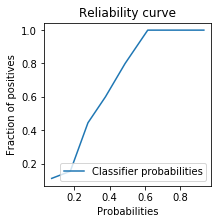

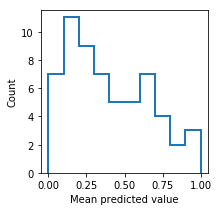

In [72]:
probability_plot(rf, train_values, train_labels['heart_disease_present']);

A bimodal distribution such as the one above is to be expected from a random forest algorithm. This could be partially fixed by a calibration step and validation data set, but I'll come back to this later.

[4.59353869e-06 2.94141244e-07 1.25693094e-04 2.36038024e-07
 1.03933135e-06 4.61638247e-07 1.91130264e-08 4.02096537e-06
 5.02383141e-09 2.65978583e-05 1.87990898e-06 1.98808534e-07
 9.24857322e-06 1.88823037e-04 6.12153625e-06 4.37164952e-05
 1.54001639e-04 4.93272617e-07 3.25228071e-08 4.39725462e-06
 6.55647954e-09 7.75345846e-07 1.45685707e-05 3.23818013e-05
 1.78730955e-05 1.26777625e-04 6.78540285e-02 7.99434481e-04
 1.03374769e-04 2.14696866e-05 3.65755844e-05 6.49775122e-05
 8.15660721e-08 1.12641656e-04 2.20246434e-07 5.73143329e-06
 6.94599746e-05 3.99744786e-04 1.72696493e-04 1.60084424e-08
 1.81876490e-06 1.34638942e-06 1.38546318e-08 1.98241458e-04
 3.02017738e-06 6.05580456e-05 3.67960361e-05 6.00210528e-08
 4.43541449e-07 7.94355868e-07 3.24044657e-07 2.13652247e-07
 1.37741226e-07 4.21838733e-07 6.66089935e-06 2.77562593e-06
 1.17835498e-04 3.75700587e-05 6.15854743e-07 8.35736255e-06]


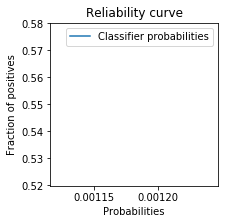

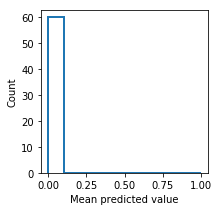

In [79]:
probability_plot(mlpc, train_values, train_labels['heart_disease_present']);

[1.02000386e-02 8.59298839e-04 7.14940666e-02 9.99995267e-01
 4.83353047e-01 8.09441793e-01 6.44643428e-05 7.50303535e-05
 1.58067311e-01 9.99986639e-01 9.99988552e-01 9.99995201e-01
 9.89188644e-01 5.77875744e-03 3.80492585e-03 1.39737799e-06
 3.36615001e-04 4.78057601e-04 9.25463998e-01 9.99975267e-01
 7.06834222e-01 3.31631280e-04 9.97812014e-01 2.15605766e-05
 2.04411399e-06 9.86191063e-01 1.35906574e-01 1.16231189e-05
 1.61158113e-07 9.99761199e-01 7.61992412e-01 7.11450010e-07
 9.94930129e-01 8.81395633e-03 9.66018152e-01 2.18457312e-06
 7.80548155e-01 9.95136029e-01 3.50010658e-01 9.88681868e-01
 6.49693427e-05 2.47990927e-01 9.95920517e-01 5.29819172e-04
 9.99187171e-01 9.54542810e-07 2.05811601e-05 2.93834670e-01
 7.21188619e-04 8.91087572e-06 2.07476118e-02 6.53297439e-04
 4.42345577e-01 9.72247246e-01 5.88221298e-03 3.16869304e-05
 9.91240111e-01 1.42841213e-03 9.98173089e-01 4.05341992e-02]


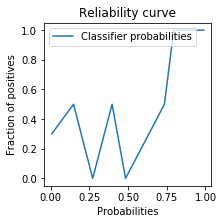

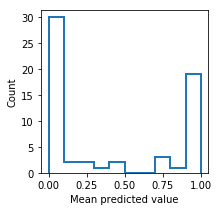

In [95]:
probability_plot(glf, train_values, train_labels['heart_disease_present']);

[0.17987936 0.16951316 0.26968507 0.92691152 0.09766858 0.73905607
 0.19401505 0.13740781 0.72625521 0.82977781 0.78428058 0.90293094
 0.63328647 0.30068632 0.3117207  0.10656002 0.14209726 0.1414534
 0.56746034 0.8249914  0.31196973 0.30689098 0.75331852 0.20397673
 0.10644769 0.54379606 0.52279168 0.11996375 0.04757345 0.62761977
 0.58737949 0.18943528 0.7750481  0.18275906 0.45984008 0.08812794
 0.46736921 0.63461098 0.17403123 0.74084989 0.08831553 0.13338568
 0.59786078 0.13253253 0.69543924 0.09247776 0.0800311  0.30357412
 0.39902728 0.16366126 0.43394312 0.13755275 0.46214679 0.42707883
 0.21838698 0.26544083 0.7084547  0.42938961 0.30788508 0.2369606 ]


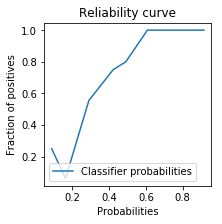

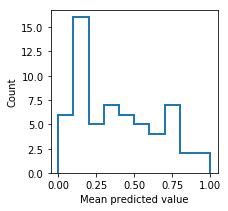

In [73]:
probability_plot(etc, train_values, train_labels['heart_disease_present']);

[0.49772097 0.48883553 0.51045111 0.54868975 0.48117555 0.51949556
 0.46867505 0.48000898 0.48434292 0.53126357 0.53472251 0.5388784
 0.5029537  0.49090297 0.48728946 0.48167196 0.5016203  0.48333899
 0.50046526 0.53595189 0.49415444 0.48752836 0.51090038 0.47899256
 0.47389819 0.50506872 0.49953937 0.47621018 0.45783465 0.5029846
 0.51379935 0.48337905 0.48102782 0.48851605 0.51287169 0.47199669
 0.51034714 0.51641889 0.50860278 0.50183844 0.47428667 0.47937919
 0.50741323 0.4977931  0.52215573 0.47070184 0.47320342 0.46897226
 0.46297388 0.47398443 0.48820062 0.46058739 0.49513479 0.50342845
 0.49824978 0.48582752 0.5219957  0.4801994  0.49856626 0.50938814]


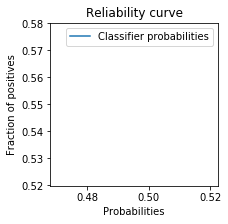

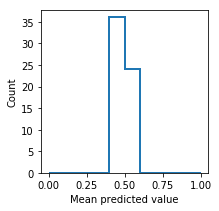

In [74]:
probability_plot(abc, train_values, train_labels['heart_disease_present']);

[0.091 0.209 0.346 0.999 0.154 0.693 0.103 0.027 0.524 0.973 0.935 0.957
 0.75  0.224 0.144 0.008 0.162 0.293 0.6   0.906 0.403 0.217 0.745 0.186
 0.027 0.651 0.457 0.035 0.036 0.707 0.548 0.035 0.892 0.231 0.647 0.118
 0.38  0.616 0.198 0.814 0.278 0.067 0.77  0.13  0.828 0.029 0.003 0.292
 0.383 0.036 0.388 0.162 0.446 0.671 0.323 0.197 0.733 0.3   0.514 0.296]


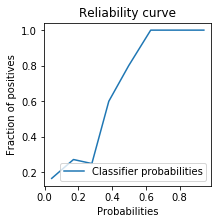

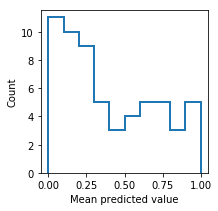

In [76]:
probability_plot(bgc, train_values, train_labels['heart_disease_present']);

The resulting distributions are *very* different. Classification probability calibration will likely need to be conducted at the end, but I will first focus on reaching the highest classification accuracy I can. 

# Tuning the models

Hyperparameter tuning works differently for different models, but the simplest way to identify the best hyperparameters for a model is just to try out various combinations of hyperparameters and evaluate their performances, choosing the hyperparameter values that result in the best performances.

## Random Forest tuning

I first use a random search which samples some hyperparameter configurations from a space of all potential combinations. I then use the best scoring combination from this search as a guess for a grid search, which methodically evaluates models using every combination of neigbhoring values from the formerly determined values.

In [84]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 8, 12, 16]
bootstrap = [True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 12, 16],
 'min_samples_split': [2, 3, 5, 7, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [85]:
RCV_rf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
RCV_rf.fit(train_values, train_labels['heart_disease_present'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 8, 12, 16], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [86]:
RCV_rf.best_params_

{'n_estimators': 944,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

Now that I've found a set of parameters that the search found to perform well, I can look closer at surrounding values to find a local optimum.

In [87]:
grid_grid = {
    'max_depth': [10, 20, 30, 60, 70, 80],
    'max_features': ["auto","sqrt"],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [8, 9, 10, 11, 12, 13, 14],
    'n_estimators': [700, 750, 800, 850, 900, 950, 1000, 1050, 1100]
}
pp.pprint(grid_grid)

{'max_depth': [10, 20, 30, 60, 70, 80],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 3, 4, 5],
 'min_samples_split': [8, 9, 10, 11, 12, 13, 14],
 'n_estimators': [700, 750, 800, 850, 900, 950, 1000, 1050, 1100]}


In [89]:
GCV_rf = GridSearchCV(estimator = rf, param_grid = grid_grid, cv = 5, n_jobs = -1, verbose = 2)
GCV_rf.fit(train_values, train_labels['heart_disease_present'])

Fitting 5 folds for each of 3024 candidates, totalling 15120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1793 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2400 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3089 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3858 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4709 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 6653 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 7746 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 8921 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 10176 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 11513 tasks    

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 60, 70, 80], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [2, 3, 4, 5], 'min_samples_split': [8, 9, 10, 11, 12, 13, 14], 'n_estimators': [700, 750, 800, 850, 900, 950, 1000, 1050, 1100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [124]:
rf_params = GCV_rf.best_params_
rf = RandomForestClassifier(**rf_params);
score(rf, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.41913068647413054
MODEL SCORE: 0.8
CV=10 SCORE: 0.8277777777777777
ROC AUC: 0.8181818181818181


Tuning the random forest model yielded a marginal increase in the cross validation score. I will take a similar approach to tuning the gradient boosting model.

## Gradient Boosting tuning

In [98]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 8, 12, 16]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pp.pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 12, 16],
 'min_samples_split': [2, 3, 5, 7, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [99]:
RCV_gb = RandomizedSearchCV(estimator = glf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
RCV_gb.fit(train_values, train_labels['heart_disease_present'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 8, 12, 16]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [100]:
RCV_gb.best_params_

{'n_estimators': 944,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40}

In [102]:
grid_grid = {
    'max_depth': [35, 37, 40, 43, 45],
    'max_features': ["auto","sqrt"],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [700, 750, 800, 850, 900, 950, 1000, 1050, 1100]
}
pp.pprint(grid_grid)

{'max_depth': [35, 37, 40, 43, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [3, 4, 5, 6, 7],
 'n_estimators': [700, 750, 800, 850, 900, 950, 1000, 1050, 1100]}


In [103]:
GCV_gb = GridSearchCV(estimator = glf, param_grid = grid_grid, cv = 5, n_jobs = -1, verbose = 2)
GCV_gb.fit(train_values, train_labels['heart_disease_present'])

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 1793 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 2400 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 3089 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 3858 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 4709 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6653 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7746 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [35, 37, 40, 43, 45], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [3, 4, 5, 6, 7], 'n_estimators': [700, 750, 800, 850, 900, 950, 1000, 1050, 1100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [104]:
GCV_gb.best_params_

{'max_depth': 37,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 750}

In [125]:
gb_params = GCV_gb.best_params_
glf = GradientBoostingClassifier(**gb_params)
score(glf, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.7617501528532592
MODEL SCORE: 0.85
CV=10 SCORE: 0.8222222222222223
ROC AUC: 0.8636363636363636


Tuning the gradient boosting model yielded around a 4% increase in the cross validation score. I want to visualize how the model's accuracy changes in response to the number of trees (n_estimators) and learning rate.

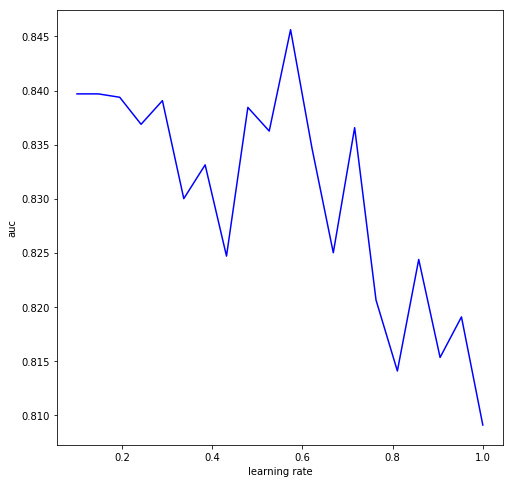

In [107]:
learning_rates = np.linspace(start = 0.1, stop = 1, num = 20)
score_results = []

for eta in learning_rates:
    model = GradientBoostingClassifier(**gb_params, learning_rate=eta)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    score_results.append(np.mean(table))
    
line1 = plt.plot(learning_rates, score_results, 'b', label="test score")
plt.ylabel('auc')
plt.xlabel('learning rate')
plt.show()

There's a downward trend, but there's nothing of value in this plot. I will stick with the default option for learning_rate.

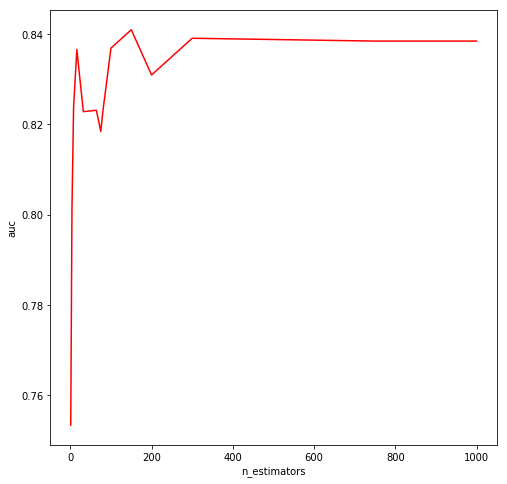

In [114]:
n_estimators = [1, 4, 8, 16, 32, 64, 75, 80, 100, 150, 200, 300, 750, 1000]
test_results = []

test_params = {'max_depth': 37,
               'max_features': 'sqrt',
               'min_samples_leaf': 3,
               'min_samples_split': 7}

for estimator in n_estimators:
    model = GradientBoostingClassifier(**test_params, learning_rate=0.6, n_estimators=estimator)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('n_estimators')
plt.show()

Looks like while there exists a point where the AUC is closer to 1 before the 750 estimator optimum identified by grid searching, it is probably not a good idea to decrease the number of estimators that low using gradient boosting, as a low number of weak estimators would not provide a robust model. I will stick with 750 estimators.

## Extra Trees tuning

In [128]:
RCV_etc = RandomizedSearchCV(estimator = etc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
RCV_etc.fit(train_values, train_labels['heart_disease_present'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 8, 12, 16]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [129]:
RCV_etc.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 12,
 'max_features': 'sqrt',
 'max_depth': None}

In [139]:
grid_grid = {
    'max_depth': [None],
    'max_features': ["sqrt"],
    'min_samples_leaf': [10, 12, 14, 15, 16],
    'min_samples_split': [8, 9, 10, 11, 12, 13, 14],
    'n_estimators': [1, 10, 20, 50, 60, 70, 80, 90, 100, 400, 1000]
}
pp.pprint(grid_grid)

{'max_depth': [None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [10, 12, 14, 15, 16],
 'min_samples_split': [8, 9, 10, 11, 12, 13, 14],
 'n_estimators': [1, 10, 20, 50, 60, 70, 80, 90, 100, 400, 1000]}


In [140]:
GCV_etc = GridSearchCV(estimator = etc, param_grid = grid_grid, cv = 5, n_jobs = -1, verbose = 2)
GCV_etc.fit(train_values, train_labels['heart_disease_present'])

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1644 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1925 out of 1925 | elapsed:   12.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [None], 'max_features': ['sqrt'], 'min_samples_leaf': [10, 12, 14, 15, 16], 'min_samples_split': [8, 9, 10, 11, 12, 13, 14], 'n_estimators': [1, 10, 20, 50, 60, 70, 80, 90, 100, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [141]:
GCV_etc.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 60}

In [142]:
etc_params = GCV_etc.best_params_
etc = ExtraTreesClassifier(**etc_params)
score(etc, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.4586011343388858
MODEL SCORE: 0.75
CV=10 SCORE: 0.8
ROC AUC: 0.7727272727272727


Extra Trees did not benefit as much from tuning, with no substantial differences from the first-pass model earlier on.

## Bagging Classifier tuning

In [168]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = np.linspace(start = 0.5, stop = 1, num = 10)
max_samples = np.linspace(start = 0.5, stop = 1, num = 10)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_samples': max_samples}
pp.pprint(random_grid)

{'max_features': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ]),
 'max_samples': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ]),
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [169]:
RCV_bgc = RandomizedSearchCV(estimator = bgc, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
RCV_bgc.fit(train_values, train_labels['heart_disease_present'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.5s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': array([0.5    , 0.55556, 0.61111, 0.66667, 0.72222, 0.77778, 0.83333,
       0.88889, 0.94444, 1.     ]), 'max_samples': array([0.5    , 0.55556, 0.61111, 0.66667, 0.72222, 0.77778, 0.83333,
       0.88889, 0.94444, 1.     ])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [170]:
RCV_bgc.best_params_

{'n_estimators': 1577,
 'max_samples': 0.6666666666666666,
 'max_features': 0.8888888888888888}

In [171]:
grid_grid = {
    'max_samples': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
    'max_features': [0.7, 0.8, 0.9, 1],
    'n_estimators': [800, 1000, 1500, 2000, 2500]
}
pp.pprint(grid_grid)

{'max_features': [0.7, 0.8, 0.9, 1],
 'max_samples': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
 'n_estimators': [800, 1000, 1500, 2000, 2500]}


In [172]:
GCV_bgc = GridSearchCV(estimator = bgc, param_grid = grid_grid, cv = 10, n_jobs = -1, verbose = 2)
GCV_bgc.fit(train_values, train_labels['heart_disease_present'])

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   49.3s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_samples': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8], 'max_features': [0.7, 0.8, 0.9, 1], 'n_estimators': [800, 1000, 1500, 2000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [173]:
GCV_bgc.best_params_

{'max_features': 0.7, 'max_samples': 0.6, 'n_estimators': 1500}

In [174]:
bgc_params = GCV_bgc.best_params_
bgc = BaggingClassifier(**bgc_params)
score(bgc, train_values, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.42527070671601586
MODEL SCORE: 0.8166666666666667
CV=10 SCORE: 0.8222222222222222
ROC AUC: 0.8333333333333333


The tuned Bagging classifier has a marginally improved cross validation score and reduced log loss.

The tuning process used above is fairly standard and could be repeated for every model described at the beginning. However, the benefits from tuning seen so far have all been fairly marginal. 

# Identifying feature interactions

The models so far are pretty good at predicting the likelihood of heart disease using the patient data provided, but can I do better? Here, I look at ways to develop new features that are non-linear combinations of existing ones to help my models understand the data in new ways.

In [176]:
rank_features(train_values, train_labels['heart_disease_present'])[:5]

,importance
reversible_defect,0.156403
chest_pain_type,0.148675
normal,0.146892
exercise_induced_angina,0.094976
num_major_vessels,0.088300


By taking the top most important features, I recursively combine features to identify combinations of features that could be useful for my models.

In [217]:
def data_combiner(values, labels, iterations=2):
    if iterations == 0:
        return values
    
    training_interactions = pd.DataFrame()
    for p1,p2 in list(itertools.combinations(values, 2)):
        training_interactions[str(p1) + "+" + str(p2)] = values[p1].astype(float) * values[p2].astype(float)
    
    top_combfeats = rank_features(training_interactions, train_labels['heart_disease_present'])[:8];
    values = pd.concat([values, training_interactions[list(top_combfeats.index)]], axis=1, sort=False)
    
    return data_combiner(values.loc[:,~values.columns.duplicated()], labels, iterations - 1)

In [218]:
rank_features(data_combiner(train_values, train_labels['heart_disease_present']), train_labels['heart_disease_present'])

,importance
chest_pain_type+slope_of_peak_exercise_st_segment+reversible_defect,0.101917
chest_pain_type+reversible_defect+slope_of_peak_exercise_st_segment+reversible_defect,0.101780
slope_of_peak_exercise_st_segment+chest_pain_type+reversible_defect,0.101007
chest_pain_type+slope_of_peak_exercise_st_segment+num_major_vessels,0.076056
max_heart_rate_achieved+normal,0.067770
max_heart_rate_achieved+max_heart_rate_achieved+normal,0.058721
normal+max_heart_rate_achieved+normal,0.054591
oldpeak_eq_st_depression+chest_pain_type+exercise_induced_angina,0.054409
chest_pain_type+reversible_defect,0.046942
oldpeak_eq_st_depression+reversible_defect,0.038319


I will identify whether the above process has any effect on the prior models.

In [228]:
train_values_interactions = data_combiner(train_values, train_labels['heart_disease_present']);

In [220]:
rf = RandomForestClassifier(**rf_params);
score(rf, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.37650894077551006
MODEL SCORE: 0.8
CV=10 SCORE: 0.8555555555555557
ROC AUC: 0.8148148148148149


In [221]:
glf = GradientBoostingClassifier(**gb_params)
score(glf, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.8434543260787158
MODEL SCORE: 0.7833333333333333
CV=10 SCORE: 0.85
ROC AUC: 0.803030303030303


In [222]:
etc = ExtraTreesClassifier(**etc_params)
score(etc, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.43663463744576747
MODEL SCORE: 0.75
CV=10 SCORE: 0.8
ROC AUC: 0.7693602693602694


In [223]:
bgc = BaggingClassifier(**bgc_params)
score(bgc, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.378713647885648
MODEL SCORE: 0.8
CV=10 SCORE: 0.8444444444444444
ROC AUC: 0.8148148148148149


The cross validation scores have increased, and log loss has decreased. This appears to be an improvement.

# Finding the best model

With a little feature engineering and some model tuning complete, the random forest model appears to consistently make higher classification accuracies than the other models. However, is it possible to build a pipeline using the random forest model as a base template that can achieve even better results?

I will apply the tree-based pipeline optimization tool (AutoML) to identify any such pipelines. 

In [229]:
tpot = TPOTClassifier(generations=50, verbosity=2, n_jobs=-1, template="RandomTree")
tpot.fit(train_values_interactions, train_labels['heart_disease_present'])

Generation 1 - Current best internal CV score: 0.8722222222222221
Generation 2 - Current best internal CV score: 0.8722222222222221
Generation 3 - Current best internal CV score: 0.8722222222222221
Generation 4 - Current best internal CV score: 0.8722222222222221
Generation 5 - Current best internal CV score: 0.8833333333333332
Generation 6 - Current best internal CV score: 0.8833333333333332
Generation 7 - Current best internal CV score: 0.8833333333333332
Generation 8 - Current best internal CV score: 0.8833333333333332
Generation 9 - Current best internal CV score: 0.8833333333333332
Generation 10 - Current best internal CV score: 0.8833333333333332
Generation 11 - Current best internal CV score: 0.8833333333333332
Generation 12 - Current best internal CV score: 0.8833333333333332
Generation 13 - Current best internal CV score: 0.8833333333333332
Generation 14 - Current best internal CV score: 0.8833333333333332
Generation 15 - Current best internal CV score: 0.8833333333333332
Gene

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=50,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring=None, subsample=1.0,
        template='RandomTree', use_dask=False, verbosity=2,
        warm_start=False)

In [230]:
tpot.export('tpot_pipeline_50_1.py')

TPOT exports code that uses the sklearn library, so it can be used here with relative ease.

In [239]:
# From TPOT generated code
tpot_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=8, min_samples_split=20)
)
score(tpot_pipeline, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 2.5353594989839805
MODEL SCORE: 0.8333333333333334
CV=10 SCORE: 0.8555555555555557
ROC AUC: 0.8417508417508417


This approach scores highly, but has a very high log loss.

In [240]:
tpot = TPOTClassifier(generations=50, verbosity=2, n_jobs=-1, template="RandomTree", scoring="neg_log_loss")
tpot.fit(train_values_interactions, train_labels['heart_disease_present'])

Generation 1 - Current best internal CV score: -0.37520933299453657
Generation 2 - Current best internal CV score: -0.37520933299453657
Generation 3 - Current best internal CV score: -0.37520933299453657
Generation 4 - Current best internal CV score: -0.375129416771036
Generation 5 - Current best internal CV score: -0.37168086848730897
Generation 6 - Current best internal CV score: -0.37168086848730897
Generation 7 - Current best internal CV score: -0.37168086848730897
Generation 8 - Current best internal CV score: -0.3652154384256924
Generation 9 - Current best internal CV score: -0.3652154384256924
Generation 10 - Current best internal CV score: -0.3498952155696958
Generation 11 - Current best internal CV score: -0.3498952155696958
Generation 12 - Current best internal CV score: -0.3498952155696958
Generation 13 - Current best internal CV score: -0.3498624507590738
Generation 14 - Current best internal CV score: -0.3498624507590738
Generation 15 - Current best internal CV score: -0.3

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=50,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring='neg_log_loss', subsample=1.0,
        template='RandomTree', use_dask=False, verbosity=2,
        warm_start=False)

In [241]:
tpot.export('tpot_pipeline_50_2.py')

In [248]:
tpot_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        make_union(
            make_union(
                StackingEstimator(estimator=svm.LinearSVC(C=5.0, dual=False, loss="squared_hinge", penalty="l1", tol=0.01)),
                FunctionTransformer(copy)
            ),
            StackingEstimator(estimator=make_pipeline(
                StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_leaf=17, min_samples_split=20)),
                DecisionTreeClassifier(criterion="entropy", max_depth=2, min_samples_leaf=20, min_samples_split=12)
            ))
        )
    ),
    RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.8500000000000001, min_samples_leaf=7, min_samples_split=9, n_estimators=100)
)
score(tpot_pipeline, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.38957021572484357
MODEL SCORE: 0.8333333333333334
CV=10 SCORE: 0.8333333333333333
ROC AUC: 0.8484848484848485


This is a much more acceptable log loss alongside improved accuracy and AUC. I will run TPOT using the prior configurations for much longer for a complete pipeline.

In [249]:
tpot = TPOTClassifier(generations=1000, verbosity=2, n_jobs=-1, template="RandomTree", scoring="neg_log_loss")
tpot.fit(train_values_interactions, train_labels['heart_disease_present'])
tpot.export('tpot_pipeline_1000.py')

Generation 1 - Current best internal CV score: -0.3747681022571704
Generation 2 - Current best internal CV score: -0.3747681022571704
Generation 3 - Current best internal CV score: -0.3747681022571704
Generation 4 - Current best internal CV score: -0.37217463808451895
Generation 5 - Current best internal CV score: -0.36911587882346
Generation 6 - Current best internal CV score: -0.36911587882346
Generation 7 - Current best internal CV score: -0.3647828931867242
Generation 8 - Current best internal CV score: -0.3647828931867242
Generation 9 - Current best internal CV score: -0.3647828931867242
Generation 10 - Current best internal CV score: -0.3647828931867242
Generation 11 - Current best internal CV score: -0.3517257196116915
Generation 12 - Current best internal CV score: -0.3517257196116915
Generation 13 - Current best internal CV score: -0.34602285920505255
Generation 14 - Current best internal CV score: -0.34602285920505255
Generation 15 - Current best internal CV score: -0.3460228

Generation 121 - Current best internal CV score: -0.2582817084582623
Generation 122 - Current best internal CV score: -0.2582817084582623
Generation 123 - Current best internal CV score: -0.2582817084582623
Generation 124 - Current best internal CV score: -0.2538317167751628
Generation 125 - Current best internal CV score: -0.2538317167751628
Generation 126 - Current best internal CV score: -0.2538317167751628
Generation 127 - Current best internal CV score: -0.2538317167751628
Generation 128 - Current best internal CV score: -0.2538317167751628
Generation 129 - Current best internal CV score: -0.2538317167751628
Generation 130 - Current best internal CV score: -0.2538317167751628
Generation 131 - Current best internal CV score: -0.2538317167751628
Generation 132 - Current best internal CV score: -0.2538317167751628
Generation 133 - Current best internal CV score: -0.2538317167751628
Generation 134 - Current best internal CV score: -0.25168187111970586
Generation 135 - Current best int

Generation 239 - Current best internal CV score: -0.24960971385051783
Generation 240 - Current best internal CV score: -0.24960971385051783
Generation 241 - Current best internal CV score: -0.24960971385051783
Generation 242 - Current best internal CV score: -0.24960971385051783
Generation 243 - Current best internal CV score: -0.24960971385051783
Generation 244 - Current best internal CV score: -0.24960971385051783
Generation 245 - Current best internal CV score: -0.24960971385051783
Generation 246 - Current best internal CV score: -0.24960971385051783
Generation 247 - Current best internal CV score: -0.24960971385051783
Generation 248 - Current best internal CV score: -0.24960971385051783
Generation 249 - Current best internal CV score: -0.24960971385051783
Generation 250 - Current best internal CV score: -0.24960971385051783
Generation 251 - Current best internal CV score: -0.24960971385051783
Generation 252 - Current best internal CV score: -0.24960971385051783
Generation 253 - Cur

Generation 357 - Current best internal CV score: -0.24960971385051783
Generation 358 - Current best internal CV score: -0.24960971385051783
Generation 359 - Current best internal CV score: -0.24960971385051783
Generation 360 - Current best internal CV score: -0.24960971385051783
Generation 361 - Current best internal CV score: -0.24960971385051783
Generation 362 - Current best internal CV score: -0.24960971385051783
Generation 363 - Current best internal CV score: -0.24960971385051783
Generation 364 - Current best internal CV score: -0.24960971385051783
Generation 365 - Current best internal CV score: -0.24960971385051783
Generation 366 - Current best internal CV score: -0.24960971385051783
Generation 367 - Current best internal CV score: -0.24960971385051783
Generation 368 - Current best internal CV score: -0.24960971385051783
Generation 369 - Current best internal CV score: -0.24960971385051783
Generation 370 - Current best internal CV score: -0.24960971385051783
Generation 371 - Cur

Generation 475 - Current best internal CV score: -0.24917047564060346
Generation 476 - Current best internal CV score: -0.2491704756406034
Generation 477 - Current best internal CV score: -0.2491704756406034
Generation 478 - Current best internal CV score: -0.2491704756406034
Generation 479 - Current best internal CV score: -0.24679351358403342
Generation 480 - Current best internal CV score: -0.24679351358403342
Generation 481 - Current best internal CV score: -0.24679351358403342
Generation 482 - Current best internal CV score: -0.24679351358403342
Generation 483 - Current best internal CV score: -0.24679351358403342
Generation 484 - Current best internal CV score: -0.24679351358403342
Generation 485 - Current best internal CV score: -0.24679351358403342
Generation 486 - Current best internal CV score: -0.24679351358403342
Generation 487 - Current best internal CV score: -0.24679351358403342
Generation 488 - Current best internal CV score: -0.24679351358403342
Generation 489 - Curren

Generation 593 - Current best internal CV score: -0.23144488931268964
Generation 594 - Current best internal CV score: -0.23144488931268964
Generation 595 - Current best internal CV score: -0.23144488931268964
Generation 596 - Current best internal CV score: -0.23144488931268964
Generation 597 - Current best internal CV score: -0.23144488931268964
Generation 598 - Current best internal CV score: -0.23144488931268964
Generation 599 - Current best internal CV score: -0.23144488931268964
Generation 600 - Current best internal CV score: -0.23144488931268964
Generation 601 - Current best internal CV score: -0.23144488931268964
Generation 602 - Current best internal CV score: -0.23144488931268964
Generation 603 - Current best internal CV score: -0.23144488931268964
Generation 604 - Current best internal CV score: -0.23144488931268964
Generation 605 - Current best internal CV score: -0.23144488931268964
Generation 606 - Current best internal CV score: -0.23144488931268964
Generation 607 - Cur

Generation 711 - Current best internal CV score: -0.22883001670069608
Generation 712 - Current best internal CV score: -0.22883001670069608
Generation 713 - Current best internal CV score: -0.22883001670069608
Generation 714 - Current best internal CV score: -0.22883001670069608
Generation 715 - Current best internal CV score: -0.22883001670069608
Generation 716 - Current best internal CV score: -0.22883001670069608
Generation 717 - Current best internal CV score: -0.22883001670069608
Generation 718 - Current best internal CV score: -0.22883001670069608
Generation 719 - Current best internal CV score: -0.22883001670069608
Generation 720 - Current best internal CV score: -0.22883001670069608
Generation 721 - Current best internal CV score: -0.22883001670069608
Generation 722 - Current best internal CV score: -0.22883001670069608
Generation 723 - Current best internal CV score: -0.22883001670069608
Generation 724 - Current best internal CV score: -0.22883001670069608
Generation 725 - Cur

Generation 829 - Current best internal CV score: -0.22686519775016212
Generation 830 - Current best internal CV score: -0.22686519775016212
Generation 831 - Current best internal CV score: -0.22686519775016212
Generation 832 - Current best internal CV score: -0.22686519775016212
Generation 833 - Current best internal CV score: -0.22686519775016212
Generation 834 - Current best internal CV score: -0.22164352604517093
Generation 835 - Current best internal CV score: -0.22164352604517093
Generation 836 - Current best internal CV score: -0.22164352604517093
Generation 837 - Current best internal CV score: -0.22164352604517093
Generation 838 - Current best internal CV score: -0.22164352604517093
Generation 839 - Current best internal CV score: -0.22164352604517093
Generation 840 - Current best internal CV score: -0.22164352604517093
Generation 841 - Current best internal CV score: -0.22164352604517093
Generation 842 - Current best internal CV score: -0.22164352604517093
Generation 843 - Cur

Generation 947 - Current best internal CV score: -0.21070182565948267
Generation 948 - Current best internal CV score: -0.21070182565948267
Generation 949 - Current best internal CV score: -0.21070182565948267
Generation 950 - Current best internal CV score: -0.21070182565948267
Generation 951 - Current best internal CV score: -0.21070182565948267
Generation 952 - Current best internal CV score: -0.21070182565948267
Generation 953 - Current best internal CV score: -0.21070182565948267
Generation 954 - Current best internal CV score: -0.21070182565948267
Generation 955 - Current best internal CV score: -0.21070182565948267
Generation 956 - Current best internal CV score: -0.21070182565948267
Generation 957 - Current best internal CV score: -0.21070182565948267
Generation 958 - Current best internal CV score: -0.21070182565948267
Generation 959 - Current best internal CV score: -0.21070182565948267
Generation 960 - Current best internal CV score: -0.21070182565948267
Generation 961 - Cur

In [269]:
tpot_pipeline_1000 = make_pipeline(
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=20, min_samples_split=7)),
    StackingEstimator(estimator=BernoulliNB(alpha=0.01, fit_prior=True)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=7, min_samples_leaf=17, min_samples_split=2)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_leaf=12, min_samples_split=10)),
    MinMaxScaler(),
    Normalizer(norm="max"),
    MinMaxScaler(),
    RobustScaler(),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0, max_depth=10, max_features=0.4, min_samples_leaf=6, min_samples_split=11, n_estimators=100, subsample=0.55)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_leaf=19, min_samples_split=19)),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.9500000000000001, min_samples_leaf=16, min_samples_split=14, n_estimators=100)),
    StackingEstimator(estimator=svm.LinearSVC(C=0.1, dual=True, loss="squared_hinge", penalty="l2", tol=0.0001)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_leaf=17, min_samples_split=14)),
    LogisticRegression(C=1.0, dual=False, penalty="l1")
)

score(tpot_pipeline_1000, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.41306023537904135
MODEL SCORE: 0.8
CV=10 SCORE: 0.8666666666666668
ROC AUC: 0.8080808080808081


Perhaps this has slightly overfit. Log loss increased and the model peforms inconsistently. So, as of now, the best models I have are my original random forest model and the second tpot pipeline.

In [263]:
rf = RandomForestClassifier(**rf_params);
score(rf, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.3772755302368762
MODEL SCORE: 0.8
CV=10 SCORE: 0.8555555555555557
ROC AUC: 0.8148148148148149


In [265]:
tpot_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        make_union(
            make_union(
                StackingEstimator(estimator=svm.LinearSVC(C=5.0, dual=False, loss="squared_hinge", penalty="l1", tol=0.01)),
                FunctionTransformer(copy)
            ),
            StackingEstimator(estimator=make_pipeline(
                StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_leaf=17, min_samples_split=20)),
                DecisionTreeClassifier(criterion="entropy", max_depth=2, min_samples_leaf=20, min_samples_split=12)
            ))
        )
    ),
    RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.8500000000000001, min_samples_leaf=7, min_samples_split=9, n_estimators=100)
)
score(tpot_pipeline, train_values_interactions, train_labels['heart_disease_present'])

K=10 LOG LOSS: 0.3765372798419076
MODEL SCORE: 0.8333333333333334
CV=10 SCORE: 0.8666666666666666
ROC AUC: 0.8451178451178453


# Adjusting probabilities

My preliminary investigation of the distributions of probability scores identified by the different models suggested that the distributions can differ greatly between models with similar accuracy metrics. This means that despite two models reaching similar classification accuracies, Datadriven could rank the two models very differently.

[0.19979047 0.17294561 0.16985487 0.99412037 0.2174612  0.86192118
 0.10750825 0.04417453 0.8231353  0.98072893 0.95450115 0.95886963
 0.82120368 0.13595819 0.12613121 0.03366363 0.09978911 0.16439563
 0.56759245 0.9286227  0.26836022 0.19463451 0.82380999 0.10923208
 0.03639503 0.73410129 0.65906413 0.05988146 0.00849667 0.83419866
 0.66784471 0.07202193 0.90101939 0.12110401 0.59244315 0.10261364
 0.42540921 0.60627565 0.08856033 0.89579221 0.1484277  0.10176761
 0.75706626 0.10238102 0.88913077 0.03612277 0.02458935 0.19659485
 0.28021462 0.05178193 0.32578479 0.15857585 0.35280336 0.54046019
 0.13107825 0.33369411 0.84734832 0.59826074 0.31517161 0.17438442]


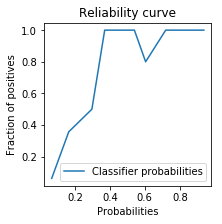

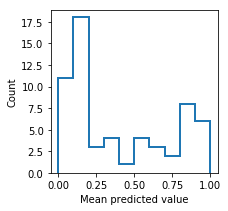

In [270]:
probability_plot(rf, train_values_interactions, train_labels['heart_disease_present']);

[0.2663138  0.16338787 0.27218148 0.99626551 0.30540894 0.93472184
 0.13184944 0.02082831 0.92989791 0.97926786 0.9039496  0.99498377
 0.89614549 0.04841352 0.06275825 0.02128821 0.07891468 0.09786748
 0.64706779 0.9648822  0.17632329 0.13082595 0.93648628 0.05864356
 0.0243261  0.77514432 0.32345395 0.04927903 0.00405332 0.90644733
 0.71500446 0.03829947 0.94643051 0.06528632 0.64823663 0.06054469
 0.61382102 0.65035946 0.07077702 0.87768733 0.11918573 0.16578877
 0.7761026  0.06469823 0.94168799 0.02447776 0.02209617 0.15235473
 0.20424389 0.09328293 0.32020528 0.12766195 0.34213962 0.71410369
 0.04526982 0.2953026  0.93299134 0.25558391 0.38465757 0.31423018]


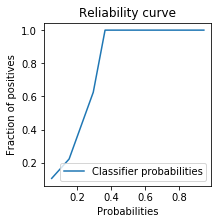

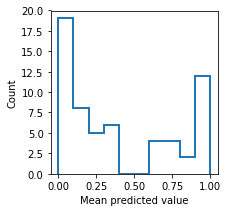

In [271]:
probability_plot(tpot_pipeline, train_values_interactions, train_labels['heart_disease_present']);

I'm also curious about the tuned Extra Trees classifier.

[0.16730218 0.17367463 0.14997712 0.90418051 0.1305727  0.81612262
 0.15306908 0.15028804 0.76336271 0.86144719 0.82205435 0.89641989
 0.7052028  0.36911743 0.364473   0.13231845 0.11010816 0.13953651
 0.41850412 0.85659258 0.2241638  0.20266495 0.83535792 0.15119382
 0.11791846 0.688901   0.6264674  0.11178508 0.07657062 0.64920626
 0.70797312 0.16374833 0.82956344 0.17188946 0.30742141 0.10935633
 0.52364117 0.63381028 0.12942313 0.8238972  0.09182571 0.12816918
 0.42531637 0.11959133 0.69716674 0.11329078 0.11552131 0.25126491
 0.25263418 0.13410025 0.26612116 0.13953604 0.29059562 0.33362441
 0.1570098  0.19324786 0.81671587 0.6072333  0.20177809 0.15844734]


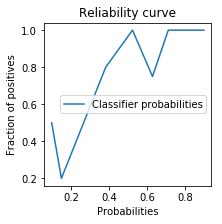

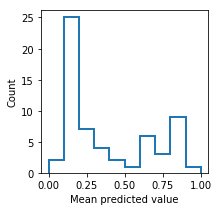

In [306]:
probability_plot(etc, train_values_interactions, train_labels['heart_disease_present']);

Both distributions appear to be quite bimodal, making a lot of high confidence predictions. The random forest model has peaks around 0.2 and 0.8, so it may likely perform better as a submission. 

I will submit both models and receive their log loss scores from Datadriven to verify my hypothesis.

In [302]:
def model_predictions_to_file(model, filename):
    test_values = pd.read_csv("data/test_values.csv")
    df_out = test_values[['patient_id']]
    test_values = ohe(test_values)
    predictions = model.predict_proba(feature_constructor(train_values_interactions, test_values))
    df_out['heart_disease_present'] = [x[1] for x in predictions]
    df_out.head()
    df_out.to_csv(filename, index=False)

In [303]:
def feature_constructor(values_interactions, values):
    df = values
    for target in values_interactions:
        if target not in df:
            cols = target.split('+')
            head = df[cols[0]]
            for combo in cols[1:]:
                head = head * df[combo]
            df[target] = head
    return df

In [304]:
rf = RandomForestClassifier(**rf_params);
rf.fit(train_values_interactions, train_labels['heart_disease_present'])
model_predictions_to_file(rf, "rf-predictions.csv")

In [305]:
tpot_pipeline.fit(train_values_interactions, train_labels['heart_disease_present'])
model_predictions_to_file(tpot_pipeline, "tpot-pipeline-predictions.csv")

In [307]:
etc.fit(train_values_interactions, train_labels['heart_disease_present'])
model_predictions_to_file(etc, "etc-predictions.csv")

The submission result for the RF model was a log loss score of 0.39340. The submission result for the TPOT model was a log loss score of 0.46692. The result for the ETC model was a log loss score of 0.4172. Probability calibration may be useful to bring the distribution peaks away from 0 and 1 (high confidence predictions). 

In [332]:
def probability_calib_plot(model, values, labels):
    import warnings
    warnings.filterwarnings('ignore')
    # creating a hold out set for the calibrated classifier
    X_train, X_test, y_train, y_test = train_test_split(values, labels, test_size=0.33, random_state=42)
    model.fit(X_train[:80],y_train[:80]);
    print("MODEL ------------------------- ")
    score(model, values, labels)
    sigmoid = CalibratedClassifierCV(model, cv=10, method='sigmoid')
    sigmoid.fit(X_train[80:],y_train[80:]);
    print("")
    print("CALIBRATED SCORE  ------------- ")
    score(sigmoid, values, labels)
    y_prob = [x[1] for x in model.predict_proba(X_test)]
    y_prob_cal = [x[1] for x in sigmoid.predict_proba(X_test)]
    from sklearn.calibration import calibration_curve
    frac, mp = calibration_curve(y_test, y_prob, n_bins=9)
    fracc, mpc = calibration_curve(y_test, y_prob_cal, n_bins=9)
    plt.figure(figsize=[10,5])
    plt.plot(mp,frac,label="Classifier probabilities")
    plt.plot(mpc,fracc,label="Calibrated probabilities")
    plt.legend()
    plt.ylabel("Fraction of positives")
    plt.xlabel("Probabilities")
    plt.title("Reliability curve")
    plt.figure(figsize=[10,5])
    if hasattr(model, "predict_proba"):
        propos = model.predict_proba(X_test)[:, 1]
        proposc = sigmoid.predict_proba(X_test)[:, 1]
    else:
        propos = model.decision_function(X_test)
        proposc = sigmoid.predict_proba(X_test)
        propos = (propos - propos.min()) / (propos.max() - propos.min())
    plt.hist(propos, range=(0,1), bins=10, histtype="step",lw=2, label="Classifier")
    plt.hist(proposc, range=(0,1), bins=10, histtype="step",lw=2, label="Sigmoid Calibrated")
    plt.xlabel("Mean predicted value")
    plt.ylabel("Count")
    plt.legend()
    return sigmoid

MODEL ------------------------- 
K=10 LOG LOSS: 0.376015663519061
MODEL SCORE: 0.8
CV=10 SCORE: 0.8611111111111113
ROC AUC: 0.8148148148148149

CALIBRATED SCORE  ------------- 
K=10 LOG LOSS: 0.40426897916470034
MODEL SCORE: 0.8
CV=10 SCORE: 0.8555555555555557
ROC AUC: 0.8148148148148149


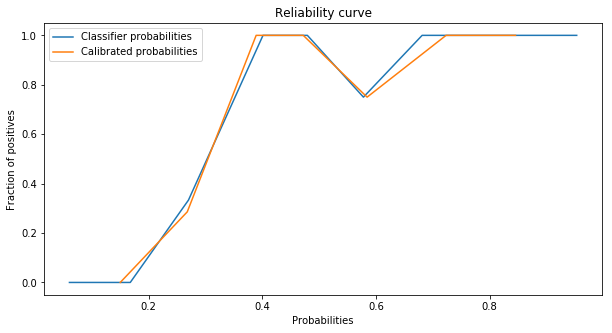

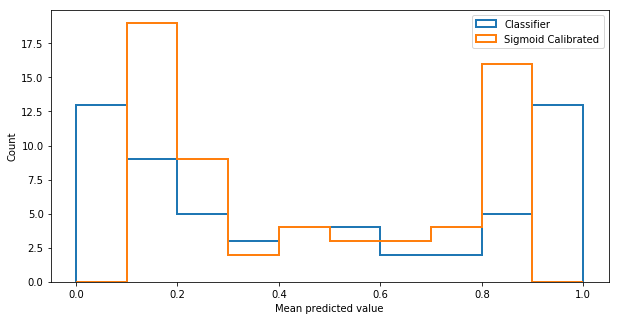

In [333]:
rf_calibrated = probability_calib_plot(rf, train_values_interactions, train_labels['heart_disease_present'])

MODEL ------------------------- 
K=10 LOG LOSS: 0.35161023985051176
MODEL SCORE: 0.85
CV=10 SCORE: 0.8333333333333334
ROC AUC: 0.8636363636363636

CALIBRATED SCORE  ------------- 
K=10 LOG LOSS: 0.4047456062789577
MODEL SCORE: 0.8333333333333334
CV=10 SCORE: 0.8555555555555555
ROC AUC: 0.8484848484848485


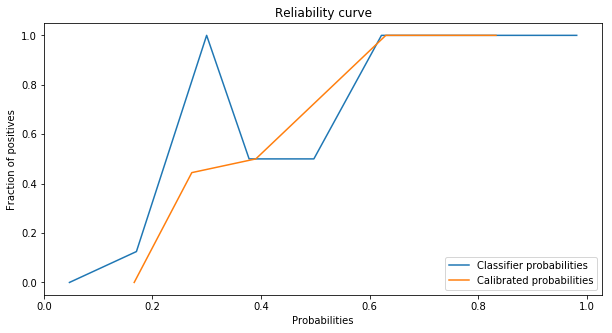

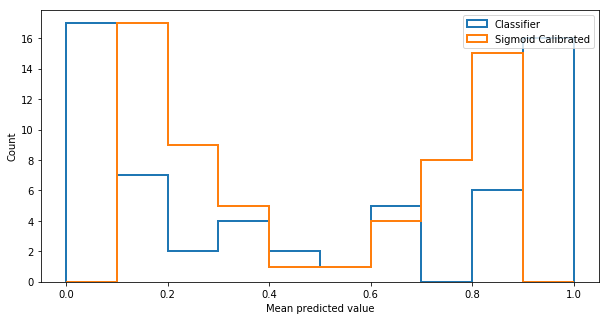

In [334]:
tpot_pipeline_calibrated = probability_calib_plot(tpot_pipeline, train_values_interactions, train_labels['heart_disease_present'])

MODEL ------------------------- 
K=10 LOG LOSS: 0.44582648133753644
MODEL SCORE: 0.75
CV=10 SCORE: 0.7944444444444445
ROC AUC: 0.7693602693602694

CALIBRATED SCORE  ------------- 
K=10 LOG LOSS: 0.45058771173108214
MODEL SCORE: 0.75
CV=10 SCORE: 0.788888888888889
ROC AUC: 0.7693602693602694


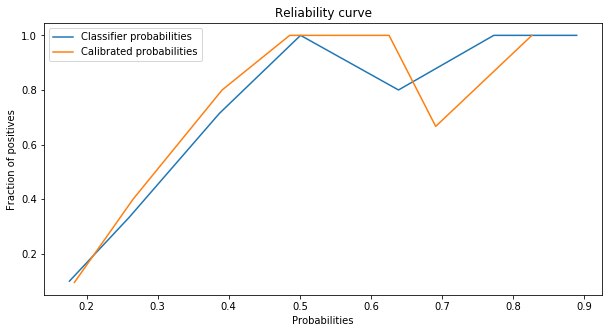

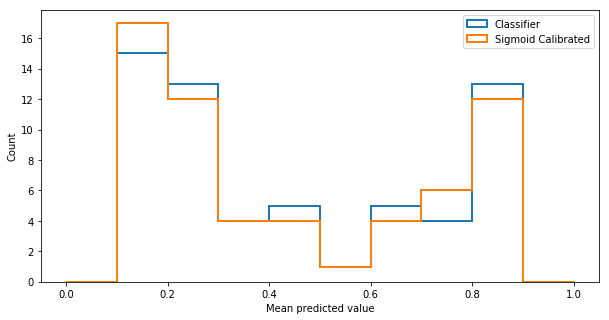

In [336]:
etc_calibrated = probability_calib_plot(etc, train_values_interactions, train_labels['heart_disease_present'])

In [337]:
rf_calibrated.fit(train_values_interactions, train_labels['heart_disease_present'])
model_predictions_to_file(rf_calibrated, "rf-calibrated-predictions.csv")

In [338]:
tpot_pipeline_calibrated.fit(train_values_interactions, train_labels['heart_disease_present'])
model_predictions_to_file(tpot_pipeline_calibrated, "tpot-pipeline-calibrated-predictions.csv")

In [339]:
etc_calibrated.fit(train_values_interactions, train_labels['heart_disease_present'])
model_predictions_to_file(etc_calibrated, "etc-calibrated-predictions.csv")

NameError: name 'etc_calibrated' is not defined